# PDFNet Example - Modern API

This notebook demonstrates PDFNet's dichotomous image segmentation using the **new, clean interface**.

## Features Covered:
1. **Simple single-image inference** using the class-based API
2. **Test-Time Augmentation (TTA)** for improved accuracy
3. **Batch processing** for efficient multi-image inference
4. **Functional API** for advanced use cases
5. **Directory processing** for production workflows

## Installation
```bash
# Install dependencies
uv pip install -e .

# Download model weights
uv run python download.py
```


## Setup


In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

# Add project to path if needed
project_root = Path.cwd()
if str(project_root / "src") not in sys.path:
    sys.path.insert(0, str(project_root / "src"))

# Import PDFNet using the new interface
from pdfnet import (
    PDFNetInference,
    load_pdfnet_model,
    run_inference,
    run_inference_with_tta,
)
from pdfnet.config import PDFNetConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Test image
TEST_IMAGE = "pics/37.png"


Using device: cuda


## Example 1: Simple Inference (Class-Based API)

The easiest way to use PDFNet is through the `PDFNetInference` class:


In [2]:
# Initialize inference engine with default settings
engine = PDFNetInference()
print("✅ Model loaded successfully")

# Run inference on a single image
mask = engine.predict_single(TEST_IMAGE)
print(f"Result shape: {mask.shape}")
print(f"Value range: [{mask.min():.3f}, {mask.max():.3f}]")


✅ Model loaded successfully
Result shape: (1500, 2000)
Value range: [0.000, 1.000]


### Visualize Result


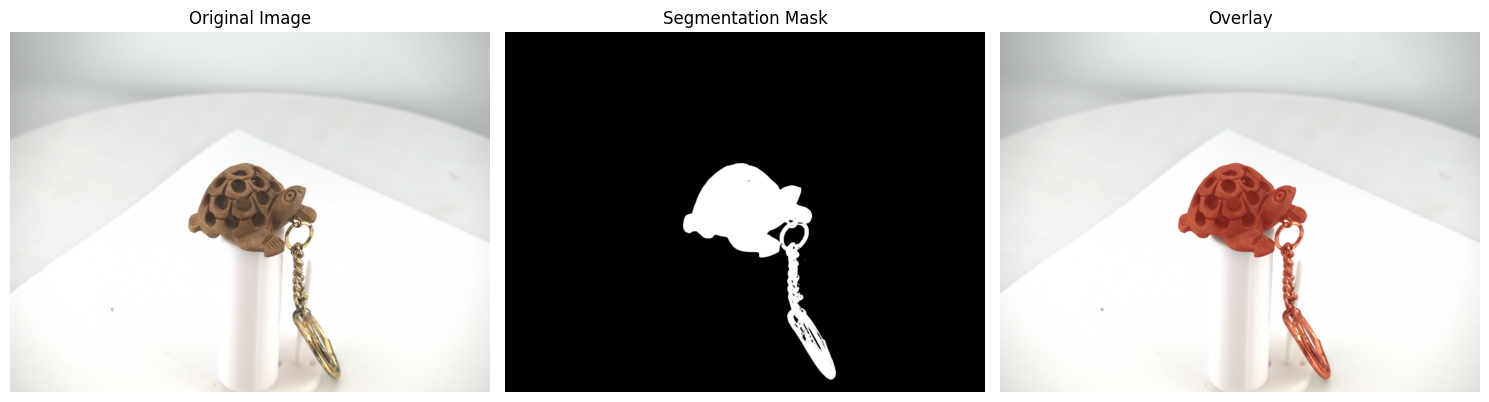

In [3]:
# Load original image
img = cv2.imread(TEST_IMAGE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")

# Overlay
overlay = img_rgb.copy()
overlay[mask > 0.5] = [255, 0, 0]  # Red overlay
axes[2].imshow(cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0))
axes[2].set_title("Overlay")
axes[2].axis("off")

plt.tight_layout()
plt.show()


## Example 2: Inference with Depth Visualization

PDFNet uses depth maps (from MoGe) for better segmentation:


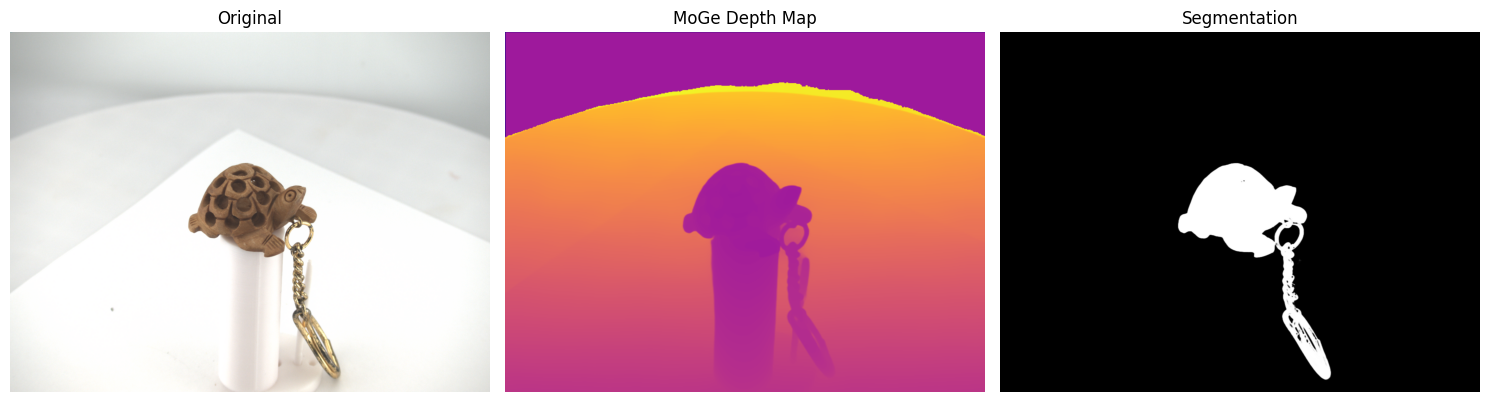

In [4]:
# Get mask and depth map
mask, depth = engine.predict_single(TEST_IMAGE, return_depth=True)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_rgb)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(depth, cmap="plasma")
axes[1].set_title("MoGe Depth Map")
axes[1].axis("off")

axes[2].imshow(mask, cmap="gray")
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.tight_layout()
plt.show()


## Example 3: Test-Time Augmentation (TTA)

TTA improves accuracy by averaging predictions from multiple augmented views:


In [5]:
# Standard inference
mask_standard = engine.predict_single(TEST_IMAGE)

# Inference with TTA (horizontal + vertical flips)
mask_tta = engine.predict_with_tta(TEST_IMAGE, flips=["horizontal", "vertical"])

print(f"Standard - range: [{mask_standard.min():.3f}, {mask_standard.max():.3f}]")
print(f"TTA      - range: [{mask_tta.min():.3f}, {mask_tta.max():.3f}]")


Standard - range: [0.000, 1.000]
TTA      - range: [0.000, 1.000]


### Compare Standard vs TTA


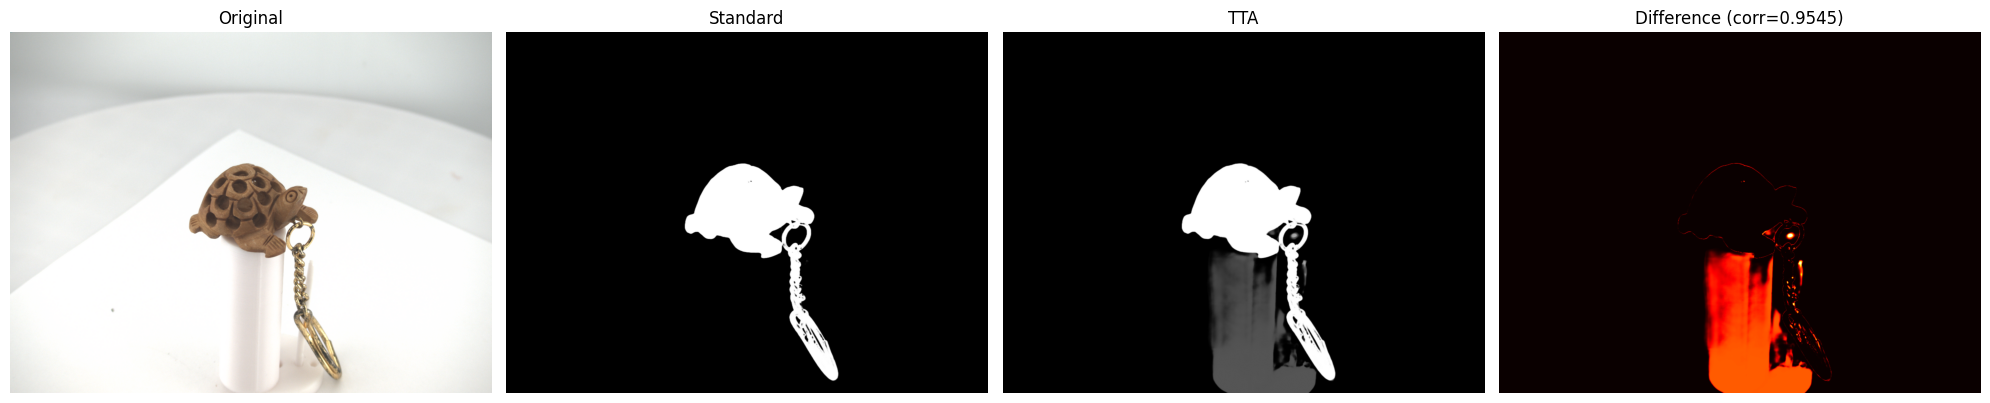

Mean difference: 0.0174
Max difference:  0.6617
Correlation:     0.9545


In [7]:
# Compute difference
diff = np.abs(mask_tta.astype(float) - mask_standard.astype(float))
correlation = np.corrcoef(mask_tta.flatten(), mask_standard.flatten())[0, 1]

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(img_rgb)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(mask_standard, cmap="gray")
axes[1].set_title("Standard")
axes[1].axis("off")

axes[2].imshow(mask_tta, cmap="gray")
axes[2].set_title("TTA")
axes[2].axis("off")

im = axes[3].imshow(diff, cmap="hot")
axes[3].set_title(f"Difference (corr={correlation:.4f})")
axes[3].axis("off")

plt.tight_layout()
plt.show()

print(f"Mean difference: {diff.mean():.4f}")
print(f"Max difference:  {diff.max():.4f}")
print(f"Correlation:     {correlation:.4f}")


## Example 4: Batch Processing

Process multiple images efficiently using true batching:


In [8]:
# Get list of test images
test_images = ["pics/37.png", "pics/01.png", "pics/DSC07956.JPG"]
test_images = [img for img in test_images if Path(img).exists()]

if len(test_images) > 0:
    print(f"Processing {len(test_images)} images...")

    # Batch inference with batch_size=4
    masks = engine.predict_batch(test_images, batch_size=4, progress=True)

    print(f"✅ Processed {len(masks)} images")
else:
    print("⚠️ Test images not found. Skipping batch processing example.")


Processing 3 images...


Processing batches: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

✅ Processed 3 images


### Visualize Batch Results


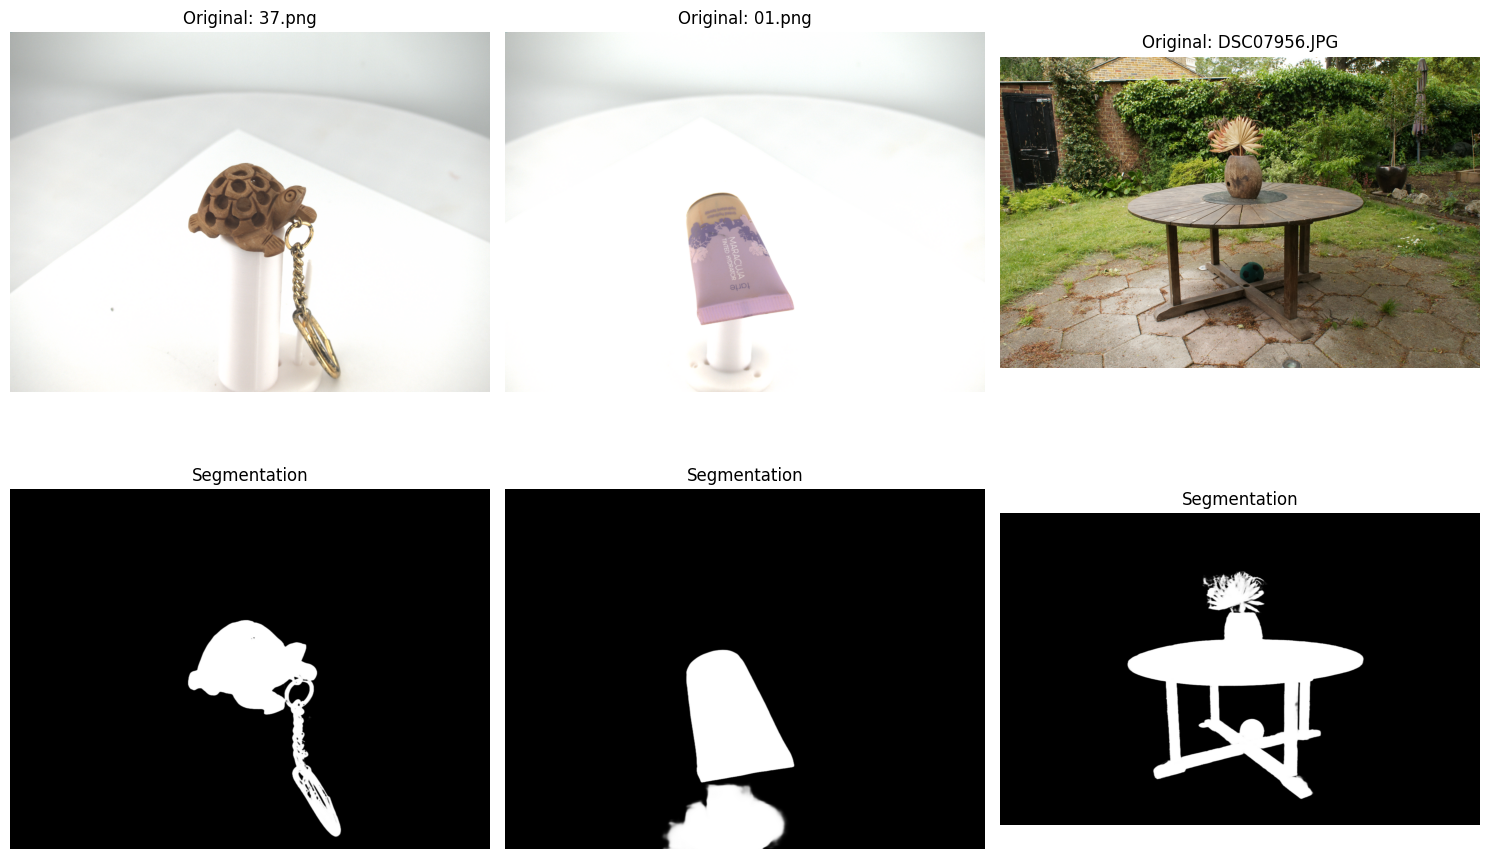

In [9]:
if len(test_images) > 0:
    num_images = len(test_images)
    fig, axes = plt.subplots(2, num_images, figsize=(5 * num_images, 10))

    if num_images == 1:
        axes = axes.reshape(2, 1)

    for i, (img_path, mask) in enumerate(zip(test_images, masks)):
        # Load image
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Original
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(f"Original: {Path(img_path).name}")
        axes[0, i].axis("off")

        # Result
        axes[1, i].imshow(mask, cmap="gray")
        axes[1, i].set_title("Segmentation")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


## Example 5: Functional API (Advanced)

For more control, use the functional API directly:


In [10]:
from pdfnet import (
    load_pdfnet_model,
    load_moge_depth_model,
    run_inference,
    run_inference_with_tta,
    save_prediction,
)

# Load models separately
model = load_pdfnet_model(
    checkpoint_path="checkpoints/PDFNet_Best.pth",
    model_name="PDFNet_swinB",
    device=device,
)

moge = load_moge_depth_model(
    checkpoint_path="checkpoints/moge/moge-2-vitl-normal/model.pt",
    device=device,
)

print("✅ Models loaded using functional API")


✅ Models loaded using functional API


### Run Inference with Functional API


✅ Result saved: output_functional.png


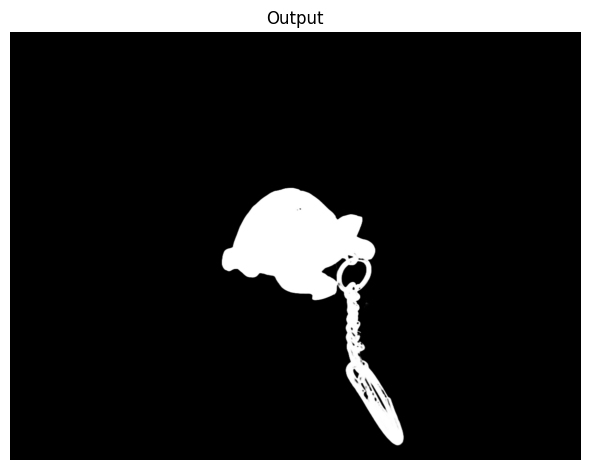

In [12]:
# Standard inference
mask = run_inference(
    model=model,
    image=TEST_IMAGE,
    depth_model=moge,
    device=device,
)

# Save result
save_prediction(mask, "output_functional.png")
print(f"✅ Result saved: output_functional.png")

plt.imshow(mask, cmap="gray")
plt.title("Output")
plt.axis("off")

plt.tight_layout()
plt.show()


### Functional API with TTA


In [13]:
# TTA with functional API
mask_tta_functional = run_inference_with_tta(
    model=model,
    image=TEST_IMAGE,
    depth_model=moge,
    device=device,
    flips=["horizontal", "vertical"],
)

# Save
save_prediction(mask_tta_functional, "output_functional_tta.png")
print(f"✅ TTA result saved: output_functional_tta.png")


✅ TTA result saved: output_functional_tta.png


## Example 6: Directory Processing

Process all images in a directory with automatic batching:


In [15]:
# Create a test directory with a few images
test_dir = Path("test_input")
test_dir.mkdir(exist_ok=True)

# Copy some test images (if available)
import shutil

for img_path in test_images[:2]:  # Copy first 2 images
    if Path(img_path).exists():
        shutil.copy(img_path, test_dir / Path(img_path).name)

if len(list(test_dir.glob("*.png"))) > 0 or len(list(test_dir.glob("*.jpg"))) > 0:
    print(f"Processing directory: {test_dir}")

    # Process entire directory with batch_size=4
    output_dir = Path("test_output")
    engine.predict_directory(
        input_dir=test_dir,
        output_dir=output_dir,
        batch_size=4,
        extensions=(".jpg", ".jpeg", ".png", ".JPG", ".PNG"),
    )

    print(f"✅ Results saved to: {output_dir}")
    print(f"Output files: {list(output_dir.glob('*.png'))}")
else:
    print("⚠️ No test images available for directory processing.")


Processing directory: test_input


Processing batches:   0%|          | 0/2 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]

✅ Results saved to: test_output
Output files: [WindowsPath('test_output/01.png'), WindowsPath('test_output/37.png')]


## Example 7: Custom Configuration

Use custom configurations for different use cases:


In [16]:
# Create custom config
config = PDFNetConfig()
config.device = str(device)
config.inference.use_moge = True
config.inference.use_tta = False
config.inference.batch_size = 8  # Larger batch size
config.model.name = "PDFNet_swinB"

# Initialize with custom config
custom_engine = PDFNetInference(
    config=config,
    checkpoint_path="checkpoints/PDFNet_Best.pth",
)

print("✅ Custom inference engine created")
print(f"   Device: {config.device}")
print(f"   Use MoGe: {config.inference.use_moge}")
print(f"   Batch size: {config.inference.batch_size}")


✅ Custom inference engine created
   Device: cuda
   Use MoGe: True
   Batch size: 8


## Example 8: Model Information

Get information about the loaded model:


In [17]:
from pdfnet import get_model_info

# Get model statistics
info = get_model_info(model)

print("Model Information:")
print(f"  Total parameters:       {info['total_params']:,}")
print(f"  Trainable parameters:   {info['trainable_params']:,}")
print(f"  Non-trainable params:   {info['non_trainable_params']:,}")
print(f"  Model size:             {info['size_mb']:.2f} MB")


Model Information:
  Total parameters:       101,693,333
  Trainable parameters:   101,693,315
  Non-trainable params:   18
  Model size:             391.73 MB


## Clean Up


In [18]:
# Clean up test directories (optional)
import shutil

for path in ["test_input", "test_output"]:
    if Path(path).exists():
        shutil.rmtree(path)
        print(f"Cleaned up: {path}")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("GPU memory cleared")


Cleaned up: test_input
Cleaned up: test_output
GPU memory cleared
